# Big Timber (6S0) Regression

Compare the observations from the Big Timber, MT AWOS (K6S0) 
with the RTMA or NBM 1hr forecast and comute a regression

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy.stats       as stats
import os.path 
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')

## Define utility functions

### load_analysis_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_analysis_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data = data.set_index(data.pop('reference_time') + data.pop('time_since_reference') * hour).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [4]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [5]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [6]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest hour

In [7]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [8]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    if left_prefix is None:
        left_prefix = ''
    else:
        left_prefix = '_{0:s}'.format(left_prefix)
    if right_prefix is None:
        right_prefix = ''
    else:
        right_prefix = '_{0:s}'.format(right_prefix)
    return pd.merge(left.add_suffix(left_prefix), right.add_suffix(right_prefix), how='inner', left_index=True, right_index=True).sort_index()

### convert_units
Convert units of columns in a DataFrame

In [9]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

## Load RTMA / NBM 1-Hour Forecast Data

In [10]:
analysis = filter_missing_data(load_analysis_grid('../data/nbm_analysis/NBM_6S0.nc', 
#                                                   from_units={'10_meter_wind_speed': 'm s**-1', '10_meter_wind_speed_of_gust': 'm s**-1'}, 
#                                                     to_units={'10_meter_wind_speed': 'knots',   '10_meter_wind_speed_of_gust': 'knots'}, 
                                                  filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust', '10_meter_wind_from_direction'], 
                                                  transform_columns=lambda a: a.replace('_mean', '')))
# convert_units(analysis, {
#     '10_meter_wind_speed': ('m s**-1', 'knots'),
#     '10_meter_wind_speed_of_gust': ('m s**-1', 'knots')
# })
analysis = filter_missing_data(analysis)
analysis

,10_meter_wind_speed,10_meter_wind_speed_of_gust,10_meter_wind_from_direction
2020-10-01 00:00:00,5.4,5.200000,50.0
2020-10-01 01:00:00,5.0,5.900000,40.0
2020-10-01 02:00:00,3.9,5.400000,50.0
2020-10-01 03:00:00,3.5,4.200000,50.0
2020-10-01 04:00:00,3.1,3.300000,40.0
...,...,...,...
2021-02-28 19:00:00,12.8,18.300001,260.0
2021-02-28 20:00:00,13.6,18.300001,260.0
2021-02-28 21:00:00,12.8,18.000000,260.0
2021-02-28 22:00:00,12.0,18.000000,260.0


## Load Observation Data

In [11]:
obs =  load_observations('../data/observations/6S0.nc', 
#                          from_units={'10_meter_wind_speed': 'm s**-1', '10_meter_wind_speed_of_gust': 'm s**-1'}, 
#                            to_units={'10_meter_wind_speed': 'knots',   '10_meter_wind_speed_of_gust': 'knots'}, 
                         filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust', '10_meter_wind_from_direction'])
# convert_units(obs,{
#     '10_meter_wind_speed': ('m s**-1', 'knots'),
#     '10_meter_wind_speed_of_gust': ('m s**-1', 'knots')
# })
replace_missing_gust_with_wind(obs, '10_meter_wind_speed', '10_meter_wind_speed_of_gust')
obs = filter_missing_data(obs)
# obs = obs[obs['10_meter_wind_speed_of_gust'] > (pint.Quantity(20, units('mph')).to(units('m s**-1')).magnitude)]
obs = get_period_maximum(obs, period='1H')
obs

,10_meter_wind_speed,10_meter_wind_speed_of_gust,10_meter_wind_from_direction
time,,,
2018-11-06 14:00:00,3.086667,3.086667,50.0
2018-11-06 15:00:00,4.115556,4.115556,30.0
2018-11-06 16:00:00,4.115556,4.115556,30.0
2018-11-06 17:00:00,3.601111,3.601111,50.0
2018-11-06 18:00:00,3.601111,3.601111,110.0
...,...,...,...
2021-03-02 20:00:00,12.346667,16.462222,270.0
2021-03-02 21:00:00,11.317778,13.890000,270.0
2021-03-02 22:00:00,10.288889,14.404444,260.0


## Time-match Observations to RTMA / NBM Analysis

In [12]:
data = time_match_dataset(obs, analysis, right_prefix='analysis')
data[]
data

,10_meter_wind_speed_obs,10_meter_wind_speed_of_gust_obs,10_meter_wind_from_direction_obs,10_meter_wind_speed_analysis,10_meter_wind_speed_of_gust_analysis,10_meter_wind_from_direction_analysis
2020-10-01 00:00:00,5.658889,7.716667,50.0,5.4,5.200000,50.0
2020-10-01 01:00:00,4.115556,4.115556,70.0,5.0,5.900000,40.0
2020-10-01 02:00:00,4.115556,4.115556,50.0,3.9,5.400000,50.0
2020-10-01 03:00:00,2.572222,2.572222,80.0,3.5,4.200000,50.0
2020-10-01 04:00:00,3.601111,3.601111,70.0,3.1,3.300000,40.0
...,...,...,...,...,...,...
2021-02-28 19:00:00,19.548889,24.178889,260.0,12.8,18.300001,260.0
2021-02-28 20:00:00,21.092222,25.722222,270.0,13.6,18.300001,260.0
2021-02-28 21:00:00,18.520000,24.693333,280.0,12.8,18.000000,260.0
2021-02-28 22:00:00,20.063333,24.693333,270.0,12.0,18.000000,260.0


## Break the data down by the ratio of observations to analysis

analysis_ratio
Analysis Over Estimates     0.377522
Analysis Under Estimates    0.622478
Name: analysis_ratio, dtype: float64


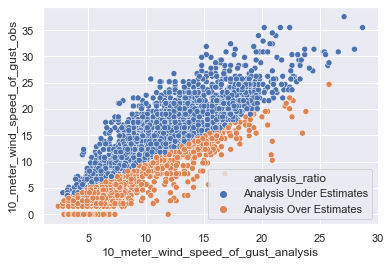

In [13]:
data['analysis_ratio'] = 'Equal'
ratio = data['10_meter_wind_speed_of_gust_obs'] / data['10_meter_wind_speed_of_gust_analysis']
data.loc[ratio > 1, 'analysis_ratio'] = 'Analysis Under Estimates'
data.loc[ratio < 1, 'analysis_ratio'] = 'Analysis Over Estimates'
del ratio
plot = sns.scatterplot(data=data, y='10_meter_wind_speed_of_gust_obs', x='10_meter_wind_speed_of_gust_analysis', hue='analysis_ratio')
print(data.groupby(['analysis_ratio']).analysis_ratio.count()/data.analysis_ratio.count())

### Filter data where analysis under estimates
Given that the analysis overwelmingly under-estimates the wind gust, only look those instances to produce as better regression

In [14]:
under_estimate = data[data.analysis_ratio == 'Analysis Under Estimates']
if os.path.exists('../data/derived/regressions.json'):
    regression = pd.read_json('../data/derived/regressions.json', orient='table')
    regression = pd.concat([regression, pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], list(stats.linregress(under_estimate['10_meter_wind_speed_of_gust_analysis'], under_estimate['10_meter_wind_speed_of_gust_obs'])))), index=['6S0'])]).reset_index().drop_duplicates(subset=['index'], keep='last').set_index('index')
    regression.index.name = None
else:
    regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], list(stats.linregress(under_estimate['10_meter_wind_speed_of_gust_analysis'], under_estimate['10_meter_wind_speed_of_gust_obs'])))), index=['6S0'])
regression.to_json('../data/derived/regressions.json', orient='table')
# regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], list(stats.linregress(under_estimate['10_meter_wind_speed_of_gust_analysis'], under_estimate['10_meter_wind_speed_of_gust_obs'])))), index=[0])
# regression.to_xarray().to_netcdf('../data/derived/6S0_regression.nc')
regression

,slope,intercept,rvalue,pvalue,stderr
1KM,0.852204,5.806669,0.800694,1.319024e-211,0.020786
6S0,1.139874,2.580342,0.842540,0.000000e+00,0.015687


### Plot Regression with data

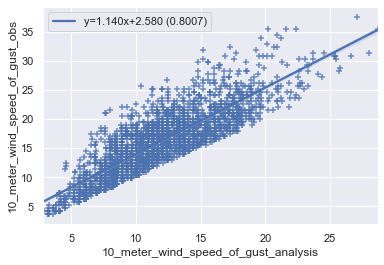

In [15]:
plot = sns.regplot(data=under_estimate, y='10_meter_wind_speed_of_gust_obs', x='10_meter_wind_speed_of_gust_analysis',marker='+', line_kws={'label':'y={0:.3f}x+{1:.3f} ({2:.4f})'.format(regression.slope['6S0'], regression.intercept['6S0'], regression.rvalue[0])})
legend = plot.legend()

In [16]:
# from windrose import WindroseAxes
# ax = WindroseAxes.from_ax()
# ax.bar(under_estimate['10_meter_wind_from_direction_obs'], under_estimate['10_meter_wind_speed_of_gust_obs'], normed=True)
# ax.set_legend()

In [17]:
# over_estimate = data[data.analysis_ratio == 'RTMA Over Estimates']
# ax = WindroseAxes.from_ax()
# ax.bar(over_estimate['10_meter_wind_from_direction_obs'], over_estimate['10_meter_wind_speed_of_gust_obs'], normed=True)
# ax.set_legend()

In [18]:
import statsmodels as sm
import statsmodels.nonparametric.kde

In [19]:
qmap_data = data[['10_meter_wind_speed_of_gust_obs', '10_meter_wind_speed_of_gust_analysis']].melt()

In [20]:
obs_kde = statsmodels.nonparametric.kde.KDEUnivariate(qmap_data[qmap_data.variable == '10_meter_wind_speed_of_gust_obs'].value)
obs_kde.fit() # Estimate the densities
analysis_kde = statsmodels.nonparametric.kde.KDEUnivariate(qmap_data[qmap_data.variable == '10_meter_wind_speed_of_gust_analysis'].value)
analysis_kde.fit() # Estimate the densities

In [21]:
data['10_meter_wind_speed_of_gust_analysis_corrected'] = data['10_meter_wind_speed_of_gust_analysis'].apply(lambda a: obs_kde.support[np.argmin(np.abs(obs_kde.cdf - analysis_kde.cdf[np.argmin(np.abs(analysis_kde.support - a))]))])

(0.0, 80.0)

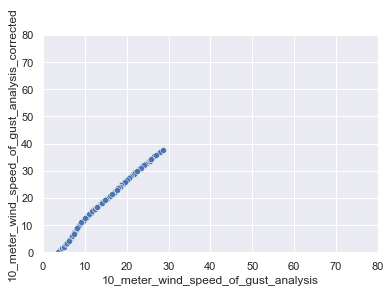

In [22]:
plot = sns.scatterplot(data=data, x='10_meter_wind_speed_of_gust_analysis', y='10_meter_wind_speed_of_gust_analysis_corrected')
plt.xlim(0,80)
plt.ylim(0,80)

In [23]:
stats.linregress(data['10_meter_wind_speed_of_gust_analysis'], data['10_meter_wind_speed_of_gust_analysis_corrected'])

LinregressResult(slope=1.6351837039797237, intercept=-5.008048580697553, rvalue=0.9939367658426153, pvalue=0.0, stderr=0.00307168100044794, intercept_stderr=0.03497747022645459)

In [24]:
regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], list(stats.linregress(under_estimate['10_meter_wind_speed_of_gust_analysis'], under_estimate['10_meter_wind_speed_of_gust_obs'])))), index=['6S0'])